# 微电网日前优化调度

基于`PuLP`建立混合整数规划模型，求解微电网日前调度问题。

## 1 问题

[第十届“中国电机工程学会杯”全国大学生电工数学建模竞赛 A 题：微电网日前优化调度](https://blog.csdn.net/Jian_Yun_Rui/article/details/72529176)

## 2 优化调度模型

基于 Python 第三方库 `PuLP`，依次建立电网、新能源（风机、光伏）及蓄电池的模型，最后组合为微电网系统优化调度模型。


开始之前先抽象一个模型基类，表示各类调度设备，包含`名称`、`容量`及`使用成本`等基本属性，同时提供一个`create_model()`方法用于实现`设计变量`、`约束`及`目标函数`三个模型相关的属性。

In [1]:
import pulp
import numpy as np


class Model:
    def __init__(self, name:str, 
                        capacity:float,         # resource capacity
                        unit_cost:float):       # unit cost when using the energy
        '''Base class for resource model, e.g., Grid, Renewable and Storage.'''
        # technical parameters
        self.name = name
        self.capacity = capacity
        self.unit_cost = unit_cost

        # linear programming model: variables, constraints and objective
        self.variables = None
        self.constraints = None
        self.objective = None

    def create_model(self, time_points:int, dt:float):
        '''How to create the LP model.'''
        raise NotImplementedError
    
    @property
    def output(self): return np.array([v.value() for v in self.variables])

### 2.1 电网模型

继承自`Model`基类，电网模型新增了`卖电收益`属性，并且满足容量约束即每个时刻的出力不能超过限定值，目标函数为运行成本即用电费用与卖电收益的差值。

In [2]:
class Grid(Model):
    def __init__(self, name:str, 
                    capacity:float, 
                    unit_cost:np.ndarray,    # unit cost when buying electricity from utility grid
                    unit_profit:np.ndarray): # unit profit when selling electricity to utility grid
        super().__init__(name, capacity, unit_cost)
        self.unit_profit = unit_profit


    def create_model(self, time_points:int, dt:float):
        # define variables at each time point
        vars_from = [pulp.LpVariable(name=f'{self.name}_from_{i}', lowBound=0) for i in range(time_points)]
        vars_to = [pulp.LpVariable(name=f'{self.name}_to_{i}', lowBound=0) for i in range(time_points)]
        self.variables = [v1-v2 for v1,v2 in zip(vars_from, vars_to)]

        # constraints: capacity limit
        # 0<=var_from<=C*b
        # 0<=var_to<=C*(1-b)
        self.constraints = []
        vars_b = [pulp.LpVariable(name=f'{self.name}_binary_{i}', cat=pulp.LpInteger) for i in range(time_points)]
        for v1,v2,b in zip(vars_from, vars_to, vars_b):
            self.constraints.append(v1<=self.capacity*b)
            self.constraints.append(v2<=self.capacity*(1-b))
        
        # objective
        self.objective = pulp.lpSum([v*x for v,x in zip(vars_from, self.unit_cost)])*dt - \
            pulp.lpSum([v*x for v,x in zip(vars_to, self.unit_profit)])*dt

### 2.2 新能源发电模型

将风机和光伏抽象为新能源发电模型，特征为每一时刻的电力供应不大于该时刻的预测出力，如果不允许弃风弃光的话，则等于预测出力值。因此，在`Model`类基础上增加两个属性：`预测出力`及`是否允许弃风弃光`。

In [3]:
class Renewable(Model):
    def __init__(self, name:str, 
                    capacity:float,
                    unit_cost:float,
                    forecast:np.ndarray,          # forecasting output
                    allow_curtailment:bool=True): # allow curtailment or not
        super().__init__(name, capacity, unit_cost)
        self.forecast = forecast
        self.allow_curtailment = allow_curtailment

    def create_model(self, time_points:int, dt:float):
        # define variables at each time point
        self.variables = [pulp.LpVariable(name=f'{self.name}_{i}', lowBound=0) for i in range(time_points)]

        # constraints:  v<=forecast
        if self.allow_curtailment:
            self.constraints = [v<=x for v,x in zip(self.variables, self.forecast)]
        else:
            self.constraints = [v==x for v,x in zip(self.variables, self.forecast)]
        
        # objective
        self.objective = pulp.lpSum(self.variables)*self.unit_cost*dt

    @property
    def utilization(self): return self.output.sum() / self.forecast.sum()

### 2.3 储能模型

根据题中对蓄电池数学模型的描述，新增`爬坡限制`、`初始SOC`、`SOC限制`、`充放电次数限制`等属性，相应的4个约束：`爬坡约束`、`容量约束`、`充放电次数约束`及`调度周期始末电量相等约束`。

In [4]:
class Storage(Model):
    def __init__(self, name:str, 
                    capacity:float, 
                    unit_cost:float,
                    capacity_limit:float, # charging / discharging ramping limit
                    init_soc:float,       # initial state of charge
                    soc_limit:list,       # SOC limit
                    cycle_limit:int):     # charing / discharging cycle counts limit
        super().__init__(name, capacity, unit_cost)
        self.init_soc = init_soc
        self.soc_limit = soc_limit
        self.cycle_limit = cycle_limit
        self.capacity_limit = capacity_limit
    
    def create_model(self, time_points: int, dt: float):
        # define variables at each time point
        vars_ch = [pulp.LpVariable(name=f'{self.name}_charge_{i}', lowBound=0) for i in range(time_points)]
        vars_dis = [pulp.LpVariable(name=f'{self.name}_discharge_{i}', lowBound=0) for i in range(time_points)]
        self.variables = [v1-v2 for v1,v2 in zip(vars_dis, vars_ch)]

        # constraints 1: ramping limit
        # 0<=var_dis<=C*b
        # 0<=var_ch<=C*(1-b)
        self.constraints = []
        vars_b = [pulp.LpVariable(name=f'{self.name}_binary_{i}', cat=pulp.LpInteger) for i in range(time_points)]
        C = self.capacity * self.capacity_limit
        for v1,v2,b in zip(vars_dis, vars_ch, vars_b):
            self.constraints.append(v1<=C*b)
            self.constraints.append(v2<=C*(1-b))
        
        # constraints 2: SOC limit
        soc = self.init_soc
        s1, s2 = self.soc_limit
        for v1,v2 in zip(vars_ch, vars_dis):
            soc += (v1*dt - v2*dt) / self.capacity
            self.constraints.append(soc>=s1)
            self.constraints.append(soc<=s2)
        
        # constraints 3: same SOC at the scheduling end
        self.constraints.append(pulp.lpSum(self.variables)==0)

        # constraints 4: charging / discharging cycle limit
        # t = |b_i-b_{i+1}|
        # sum(t)<=N
        vars_db = [vars_b[i+1]-vars_b[i] for i in range(time_points-1)]
        vars_t = [pulp.LpVariable(name=f'{self.name}_binary_t_{i}', cat=pulp.LpInteger) for i in range(time_points-1)]
        for db, t in zip(vars_db, vars_t):
            self.constraints.append(db>=-t)
            self.constraints.append(db<=t)
        self.constraints.append(pulp.lpSum(vars_t)<=self.cycle_limit)

        # objective
        self.objective = pulp.lpSum(vars_dis)*self.unit_cost*dt

### 2.4 优化调度模型

抽象出一个微电网类，包含上述能源设备及负荷，综合各设备的约束及系统能量平衡，建立最终的优化模型。

In [12]:
import matplotlib.pyplot as plt


class MicroGrid:
    def __init__(self, resources:list, load:np.ndarray, time_step:float) -> None:
        self.resources = resources
        self.load = load
        self.time_step = time_step

        # create problem: minimize the operation cost
        self.prob = pulp.LpProblem(name='microgrid_optimization', sense=pulp.LpMinimize)
    
    @property
    def operation_cost(self): return self.prob.objective.value()

    @property
    def average_cost(self): return self.operation_cost / (self.load.sum()*self.time_step)

    def optimize(self):
        '''Micro-grid operation optimization.'''
        # collect resources models
        d_variables, constraints, objective = [], [], 0.0
        time_points = self.load.size
        for resource in self.resources:
            resource.create_model(time_points, self.time_step)
            d_variables.append(resource.variables)
            constraints.extend(resource.constraints)
            objective += resource.objective
        
        # add constraints: resource level
        for c in constraints: self.prob += c

        # add constraint: energy balance
        for i in range(time_points):
            _vars = [variables[i] for variables in d_variables]
            self.prob += pulp.lpSum(_vars)==self.load[i]
        
        # objective
        self.prob += objective

        # solve
        self.prob.solve()

        # output
        self._summary()

    def _summary(self):
        print(f'Status: {pulp.LpStatus[self.prob.status]}')
        print(f'全天总供电费用：{round(self.operation_cost,4)} 元，负荷平均购电单价：{round(self.average_cost,4)} 元/kWh')        
        # plot
        for r in self.resources: plt.plot(r.output, label=r.name)
        plt.plot(self.load, label='load')
        plt.legend()
        plt.savefig('plot.png', dpi=300)

## 3 计算结果

先导入时间序列数据，然后计算不同场景。

In [6]:
# read text to list
with open('input.csv', 'r', encoding='utf-8') as f: lines = f.readlines()

# print the first three lines for example
for line in lines[:3]: print(line)

# list to numpy 2D array
data = [list(map(float, line.split(','))) for line in lines[1:]] # except the header line
data = np.array(data)

data_load, data_wt, data_pv, unit_profit, unit_cost = [data[:, i] for i in range(1,6)]

序号,负荷(kW),风机(kW),光伏(kW),售电(元/kWh),购电(元/kWh)

1,64.3,163.1,0,0.22,0.25

2,65.5,201.47,0,0.22,0.25



### 3.1 经济性评估方案

若微网中蓄电池不作用，且微网与电网交换功率无约束，在**无可再生能源**情况下，计算各时段负荷的供电构成（kW）、全天总供电费用(元)和负荷平均购电单价（元/kWh）。

Status: Optimal
全天总供电费用：1976.4142 元，负荷平均购电单价：0.5976 元/kWh


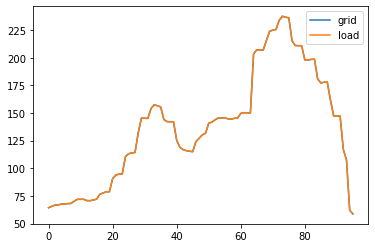

In [7]:
# set a large value 1e6 as no limit on energy exchanging with grid
grid = Grid(name='grid', capacity=1e6, unit_cost=unit_cost, unit_profit=unit_profit) 

# microgrid
resources=[grid]
mg = MicroGrid(resources=resources, load=data_load, time_step=15/60) # 15min
mg.optimize()

若微网中蓄电池不作用，且微网与电网交换功率无约束，在**可再生能源全额利用**情况下，计算各时段负荷的供电构成（kW）、全天总供电费用(元)和负荷平均购电单价（元/kWh）。

Status: Optimal
全天总供电费用：2275.1698 元，负荷平均购电单价：0.6879 元/kWh
弃风率：0.0，弃光率：0.0


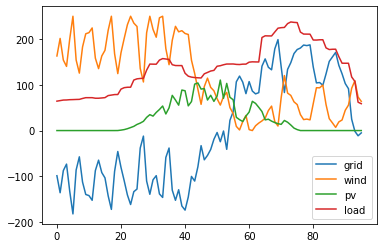

In [8]:
# set a large value 1e6 as no limit on energy exchanging with grid
grid = Grid(name='grid', capacity=1e6, unit_cost=unit_cost, unit_profit=unit_profit) 

# wind turbine
wt = Renewable(name='wind', capacity=250, unit_cost=0.52, forecast=data_wt, allow_curtailment=False)

# pv
pv = Renewable(name='pv', capacity=150, unit_cost=0.75, forecast=data_pv, allow_curtailment=False)

# microgrid
resources=[grid, wt, pv]
mg = MicroGrid(resources=resources, load=data_load, time_step=15/60) # 15min
mg.optimize()

print(f'弃风率：{round(1-wt.utilization,4)}，弃光率：{round(1-pv.utilization, 4)}')

### 3.2 最优日前调度方案一

若不计蓄电池作用，且微网与电网交换功率无约束，以平均负荷供电单价最小为目标（允许弃风弃光），分别计算各时段负荷的供电构成（kW）、全天总供电费用(元)和平均购电单价（元/kWh），分析可再生能源的利用情况。

Status: Optimal
全天总供电费用：1785.1532 元，负荷平均购电单价：0.5397 元/kWh
弃风率：0.5399，弃光率：0.6923


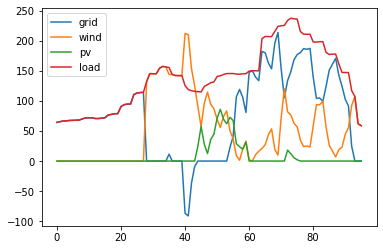

In [13]:
# set a large value 1e6 as no limit on energy exchanging with grid
grid = Grid(name='grid', capacity=1e6, unit_cost=unit_cost, unit_profit=unit_profit) 

# wind turbine
wt = Renewable(name='wind', capacity=250, unit_cost=0.52, forecast=data_wt, allow_curtailment=True)

# pv
pv = Renewable(name='pv', capacity=150, unit_cost=0.75, forecast=data_pv, allow_curtailment=True)

# microgrid
resources=[grid, wt, pv]
mg = MicroGrid(resources=resources, load=data_load, time_step=15/60) # 15min
mg.optimize()

print(f'弃风率：{round(1-wt.utilization,4)}，弃光率：{round(1-pv.utilization, 4)}')

### 3.3 最优日前调度方案二

若考虑蓄电池作用，且微网与电网允许交换功率不超过 150kW，在可再生能源全额利用的条件下，以负荷平均供电单价最小为目标，建立优化模型，给出最优调度方案，包括各时段负荷的供电构成（kW）、全天总供电费用(元)和平均购电单价（元/kWh），分析蓄电池参与调节后产生的影响。

Status: Optimal
全天总供电费用：2210.4672 元，负荷平均购电单价：0.6683 元/kWh
弃风率：0.0，弃光率：0.0


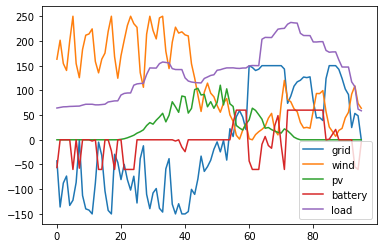

In [14]:
# grid
grid = Grid(name='grid', capacity=150, unit_cost=unit_cost, unit_profit=unit_profit) 

# wind turbine
wt = Renewable(name='wind', capacity=250, unit_cost=0.52, forecast=data_wt, allow_curtailment=False)

# pv: allow_curtailment=False
pv = Renewable(name='pv', capacity=150, unit_cost=0.75, forecast=data_pv, allow_curtailment=False)

# battery: allow_curtailment=False
bt = Storage(name='battery', capacity=300, unit_cost=0.2, capacity_limit=0.2, init_soc=0.4, soc_limit=[0.3,0.95], cycle_limit=8)

# microgrid
resources=[grid, wt, pv, bt]
mg = MicroGrid(resources=resources, load=data_load, time_step=15/60) # 15min
mg.optimize()

print(f'弃风率：{round(1-wt.utilization,4)}，弃光率：{round(1-pv.utilization, 4)}')

### 3.4 最优日前调度方案三

若考虑蓄电池作用，且微网与电网允许交换功率不超过 150kW，以负荷供电成本最小为目标（允许弃风弃光），建立优化模型，给出最优调度方案，包括各时段负荷的供电构成（kW）、全天总供电费用(元)和平均购电单价（元/kWh），分析可再生能源的利用情况及蓄电池参与调节后产生的影响。

Status: Optimal
全天总供电费用：1733.5558 元，负荷平均购电单价：0.5241 元/kWh
弃风率：0.5383，弃光率：0.6494


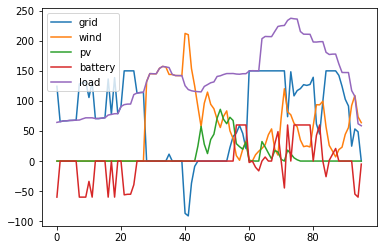

In [15]:
# grid
grid = Grid(name='grid', capacity=150, unit_cost=unit_cost, unit_profit=unit_profit) 

# wind turbine
wt = Renewable(name='wind', capacity=250, unit_cost=0.52, forecast=data_wt, allow_curtailment=True)

# pv: allow_curtailment=True
pv = Renewable(name='pv', capacity=150, unit_cost=0.75, forecast=data_pv, allow_curtailment=True)

# battery: allow_curtailment=True
bt = Storage(name='battery', capacity=300, unit_cost=0.2, capacity_limit=0.2, init_soc=0.4, soc_limit=[0.3,0.95], cycle_limit=8)

# microgrid
resources=[grid, wt, pv, bt]
mg = MicroGrid(resources=resources, load=data_load, time_step=15/60) # 15min
mg.optimize()

print(f'弃风率：{round(1-wt.utilization,4)}，弃光率：{round(1-pv.utilization, 4)}')